In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import os
from sklearn.metrics import r2_score
import pickle

# Subnetwork

In [2]:
predicted_nodes = [
    "RB",
    "ERK12",
    "JNK",
    "cleavedCas",
    "p38",
    "MKK36",
    "MAPKAPK2",
    "p90RSK",
    "p53",
    "CREB",
    "H3",
    "MEK12",]

In [3]:
client = mlflow.tracking.MlflowClient(tracking_uri="http://localhost:5000")
exp_id = client.get_experiment_by_name("OneCellLine").experiment_id
runs = client.search_runs(experiment_ids=exp_id)
runs_df = pd.DataFrame([{ **dict(run.info), **run.data.params, **run.data.metrics} for run in runs])

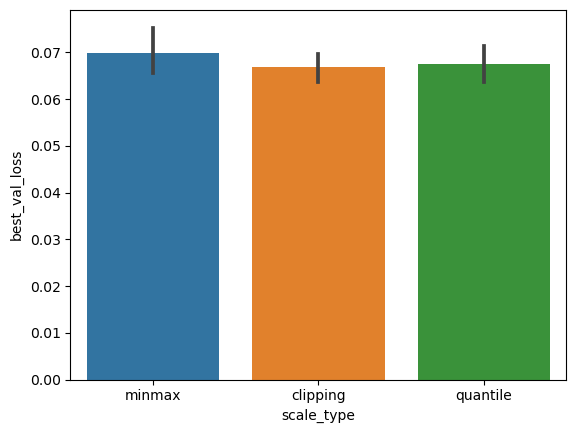

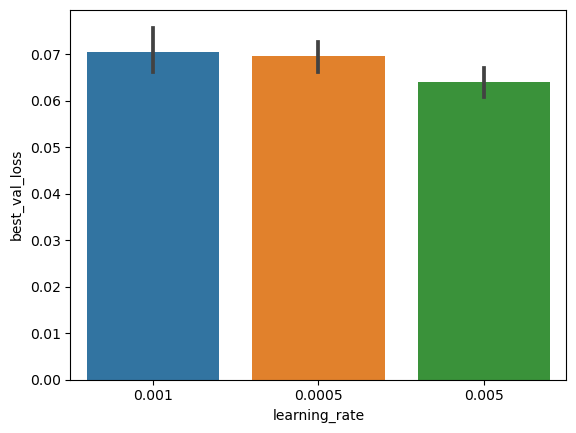

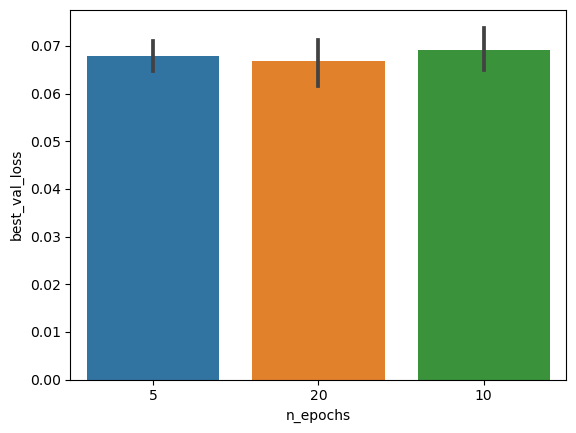

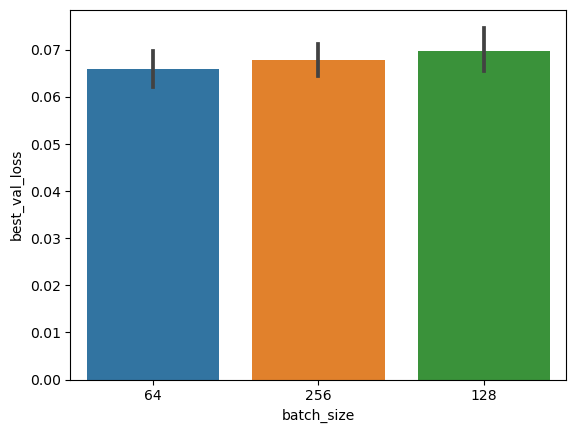

In [4]:

sns.barplot(data=runs_df, x="scale_type", y="best_val_loss")
plt.show()
sns.barplot(data=runs_df, x="learning_rate", y="best_val_loss")
plt.show()
sns.barplot(data=runs_df, x="n_epochs", y="best_val_loss")
plt.show()
sns.barplot(data=runs_df, x="batch_size", y="best_val_loss")
plt.show()

In [5]:
best_run = runs_df.sort_values("best_val_loss", ascending=True).iloc[0,:]

In [6]:
print(best_run["param_setting"])
print(best_run["scale_type"])
print(best_run["n_epochs"])
print(best_run["batch_size"])

22
quantile
10
64


In [7]:
for n in predicted_nodes:
    print(n, best_run[f"val_r2_{n}"])



RB 0.042751709346395605
ERK12 -3.000077591077301
JNK -1.9145644785268985
cleavedCas -0.3262692962720444
p38 -2.625159723685486
MKK36 -1.0999461564307365
MAPKAPK2 -0.44454342679575487
p90RSK -9.249296406928591
p53 -0.12994649008489612
CREB -0.6364727739306468
H3 -0.33510804015399365
MEK12 -20.87820149361771


In [8]:
model_dir = "/Users/adr/Box/CARs/BFN/Model/OneCellLine/"
m_test = pd.read_csv(os.path.join(model_dir, "valid_data.csv"), index_col = 0).reset_index(drop=True)
m_pred = pd.read_csv(os.path.join(model_dir, "valid_output_states.csv"), index_col=0)
with open(os.path.join(model_dir, "scaler.pkl"), "rb") as s:
    m_scaler = pickle.load(s)

/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
m_scaler

MinMaxScaler()

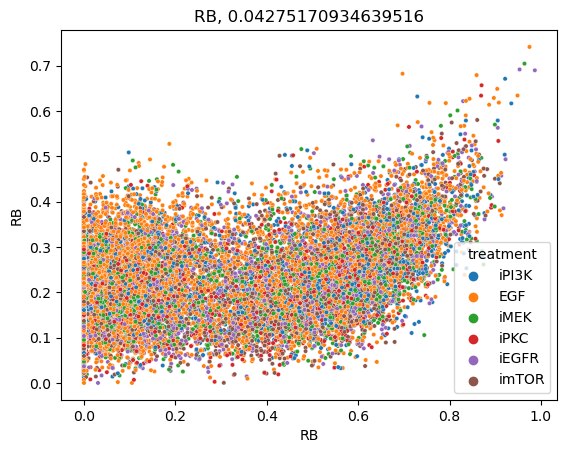

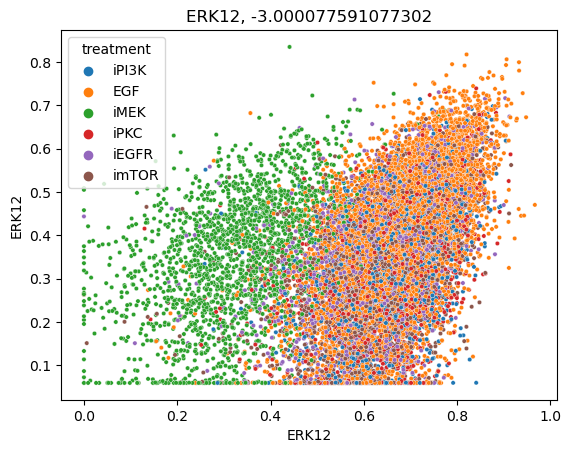

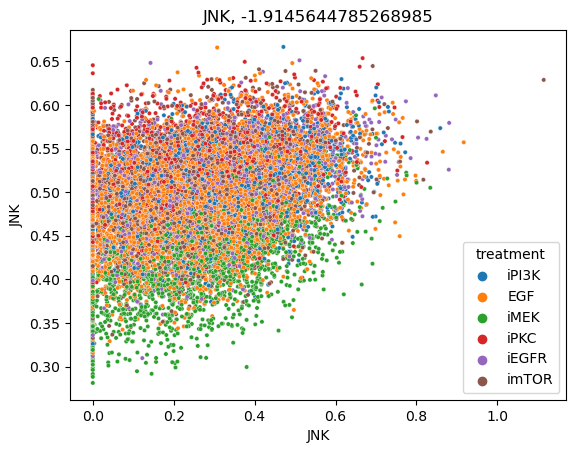

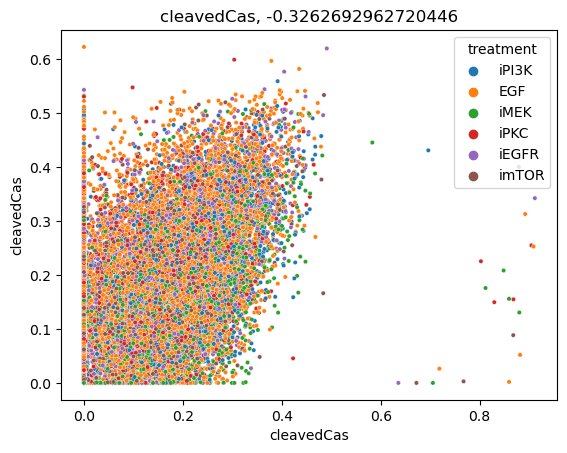

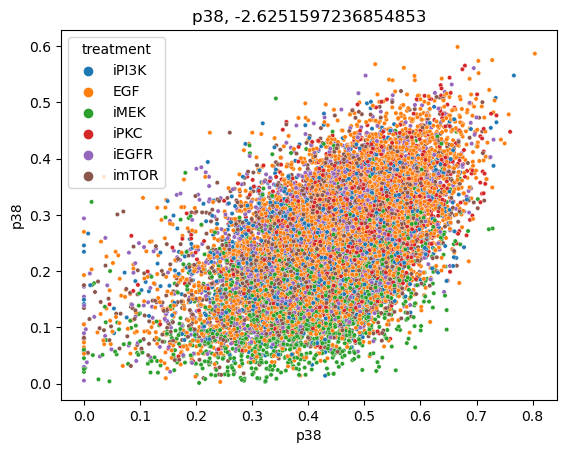

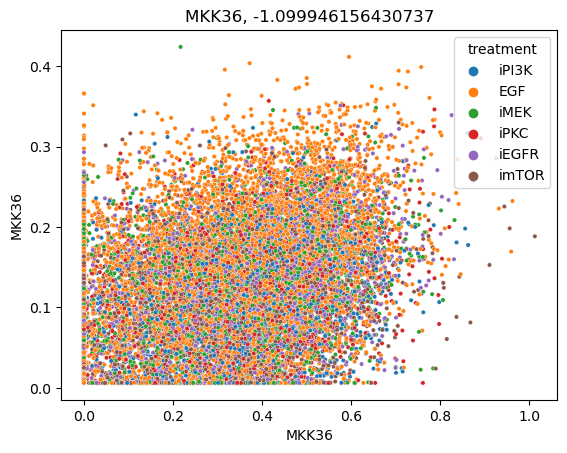

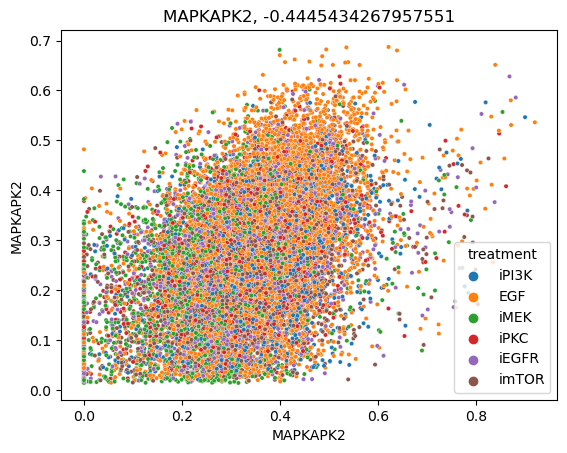

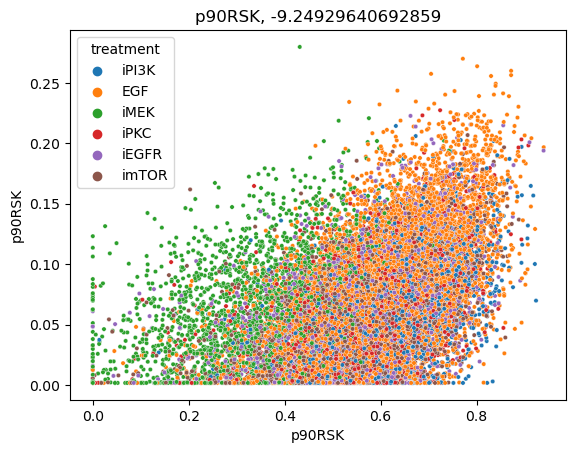

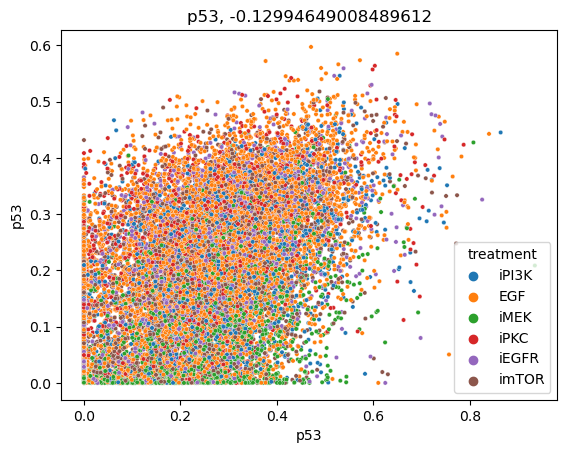

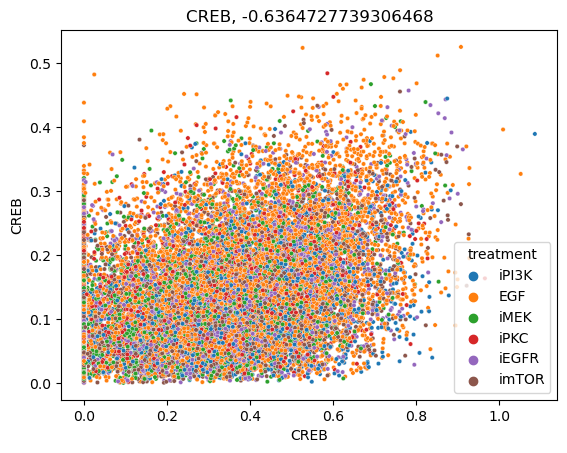

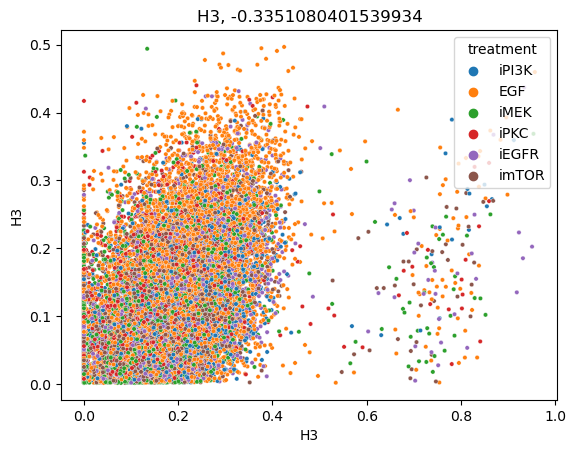

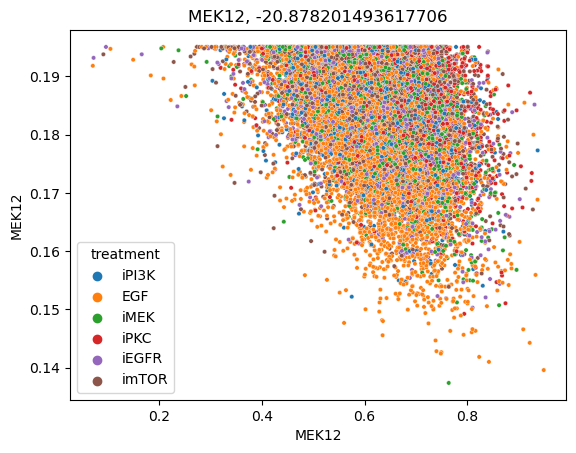

In [10]:
m_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=m_test[n], y=m_pred[n], hue=m_test["treatment"], s =10)
    r2 = r2_score(m_test[n], m_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    m_r2.append(r2)

In [11]:
baseline_dir = "/Users/adr/Box/CARs/BFN/Model/Baseline/RF_OneCellLine_SN_inputs/"
bl_test = np.load(os.path.join(baseline_dir, "RF_OneCellLine_test.npy"), allow_pickle=True)
bl_test = pd.DataFrame(bl_test).iloc[:, :40]
bl_test.columns = m_test.iloc[:, :40].columns

In [12]:
bl_test

treatment cell_line time b-catenin cleavedCas  CyclinB     GAPDH  \
0          iMEK      BT20  9.0  0.224784   1.727947  1.27779  0.655434   
1         imTOR      BT20  9.0  2.189205   0.898342  4.97938  3.407339   
2         iEGFR      BT20  9.0  1.200229   3.235354  2.13839  3.023194   
3           EGF      BT20  9.0  1.867369   2.995834  5.29216  3.241137   
4         iPI3K      BT20  9.0  1.039901   0.898342  1.28341  0.946065   
...         ...       ...  ...       ...        ...      ...       ...   
16244     imTOR      BT20  9.0  1.273969   1.771246  2.00856  2.703349   
16245       EGF      BT20  9.0  0.632672   2.040927  1.30453  2.005783   
16246      iMEK      BT20  9.0  0.479705   3.336735  2.48473  1.304254   
16247       EGF      BT20  9.0  1.862915   2.288681  1.42557  2.899606   
16248       EGF      BT20  9.0  0.691597   4.021345   2.9733  1.576879   

            IdU    Ki.67     4EBP1  ...     PDPK1     PLCg2       RB       S6  \
0      10.36076  1.73781  0.993163  ...  0.816308   2.58755  5.30588  6.13016   
1      10.89748   5.1006  4.484524  ...  2.262321       NaN  7.83142  5.98177   
2       5.82614  3.24962  0.993163  ...  2.369137  1.513375  2.47417  7.91084   
3       4.91834   5.2336   3.74705  ...  2.549657  3.625277  7.19781  7.87485   
4       4.85073  2.57312   2.21132  ...  1.046701   3.44847  2.20794  5.59959   
...         ...      ...       ...  ...       ...       ...      ...      ...   
16244   5.13924  3.70847  3.152666  ...  1.357787       NaN  3.87517  4.03521   
16245   5.29348  1.59085  2.850569  ...  0.516309  3.190278  3.23315  4.25254   
16246  11.59116  1.64361  3.276293  ...  0.516309   4.26817  5.97722  7.56129   
16247    4.2502  4.12469  4.353348  ...  1.870949  4.410349  3.15139  5.34069   
16248   11.0425   3.4905  2.277902  ...  1.625823  3.740584  7.30333  7.80213   

         p70S6K    SMAD23       SRC     STAT1     STAT3     STAT5  
0      2.009625  1.684779  2.584994  2.405381  2.025791  3.323574  
1      3.335362  3.162414  2.781374   4.01791  5.040578  3.359501  
2      2.327987  1.815579  2.808952  3.764963  1.821749  3.001342  
3      2.688123  2.697812  3.063391  4.323443  2.581907  3.453672  
4      2.433135  2.412654  2.733134  2.403898  2.733325  2.804554  
...         ...       ...       ...       ...       ...       ...  
16244   2.67001  2.828163  2.511799   3.21461  3.661784  2.973349  
16245  1.906994  0.943037  3.487888  3.161516  1.906657  3.159032  
16246  2.517317  0.551474  2.603838  2.984292  5.025403  3.656842  
16247  2.465086  2.509136  1.662605  3.105385  3.060415  2.693184  
16248  1.712796  2.554021  3.628099  3.428176  2.464668  3.357328  

[16249 rows x 40 columns]

In [13]:
all_pred = []
names = []
for f in os.listdir(baseline_dir):
    if not f.startswith("RF_"):
        pred = np.load(os.path.join(baseline_dir, f))
        if "Cas" in f:
            name = f[:-4]
        elif "MEK" in f or "ERK" in f:
            name = f"{f[2:-4]}12"
        elif "MKK3.MKK6" in f:
            name = "MKK36"
        else:
            name = f[2:-4]
        
        all_pred.append(pred)
        names.append(name)
        
        print(name)

MKK36
p53
H3
MAPKAPK2
p90RSK
CREB
p38
JNK
ERK12
MEK12
RB
cleavedCas


In [14]:
bl_pred = pd.DataFrame(all_pred).T
bl_pred.columns = names
bl_pred

MKK36       p53        H3  MAPKAPK2    p90RSK      CREB       p38  \
0      1.274049  1.798866  1.947785  1.650278  2.336390  0.958684  2.716151   
1      2.641176  3.569444  3.635804  3.388292  5.537233  1.851992  3.542033   
2      2.328045  3.056625  3.577946  2.983809  5.351665  1.546595  3.469685   
3      2.217914  3.370801  3.497497  3.627549  5.329971  1.895052  4.121478   
4      1.439859  1.864618  2.454854  2.360255  4.265156  1.182419  2.808840   
...         ...       ...       ...       ...       ...       ...       ...   
16244  2.182006  2.458918  3.243532  2.870826  4.895501  1.730036  3.400279   
16245  1.829617  2.121030  2.222760  2.796012  4.443079  1.510853  3.430691   
16246  1.776784  2.393952  2.373137  2.220898  3.304208  1.179213  3.135394   
16247  1.977728  2.246663  2.899478  2.787336  4.834652  1.483499  3.078289   
16248  2.062641  2.300329  3.074478  2.932690  5.098444  1.582760  3.251480   

            JNK     ERK12     MEK12        RB  cleavedCas  
0      1.178242  1.769153  3.127871  3.460694    1.697939  
1      2.169689  4.927475  4.442491  6.634959    3.129921  
2      1.852477  4.780207  4.196705  5.789126    2.931205  
3      1.827630  5.052393  4.621319  6.822714    2.416754  
4      1.604590  3.838975  3.187901  4.578733    1.976198  
...         ...       ...       ...       ...         ...  
16244  1.777880  4.431776  4.059121  5.369343    2.611232  
16245  1.454583  4.305278  3.673444  3.131205    1.839938  
16246  1.669528  2.422975  3.874210  4.802121    2.296598  
16247  1.946546  4.244599  3.588899  3.976997    2.473046  
16248  1.711169  4.517800  3.470355  3.125212    2.032987  

[16249 rows x 12 columns]

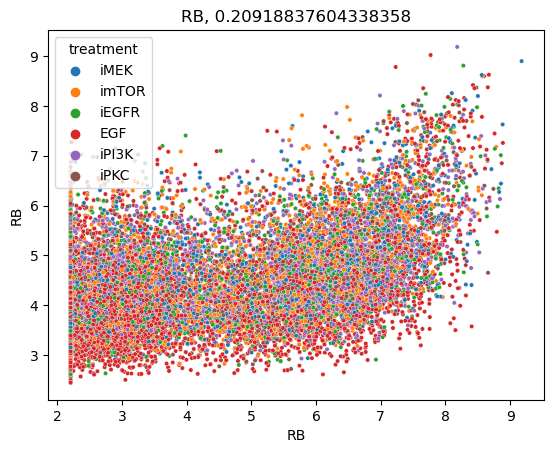

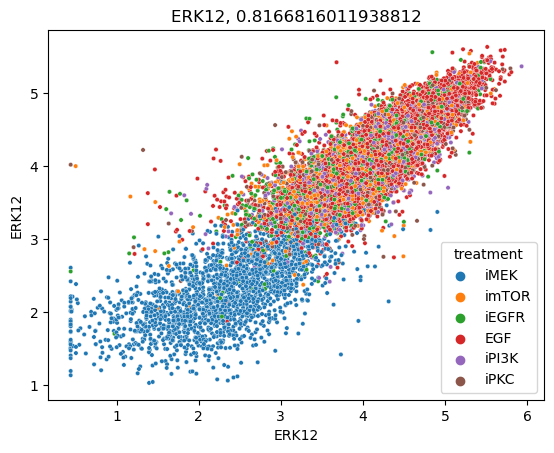

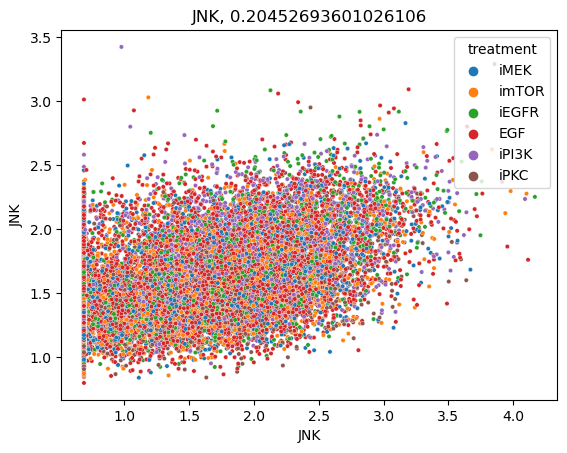

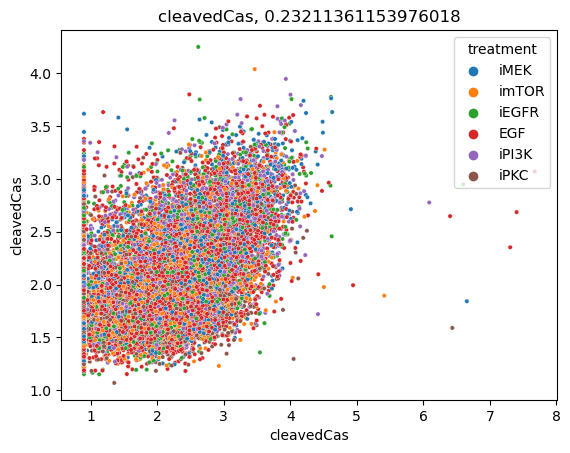

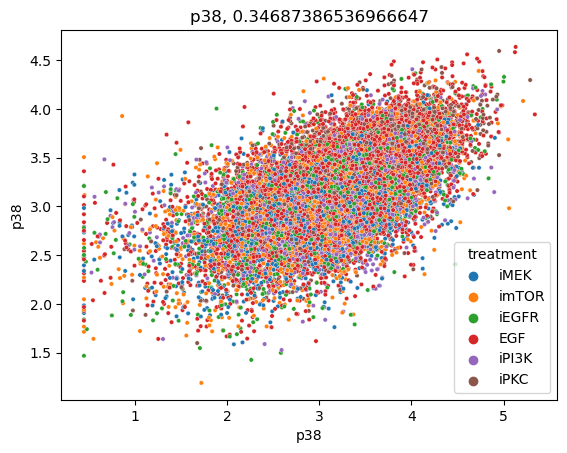

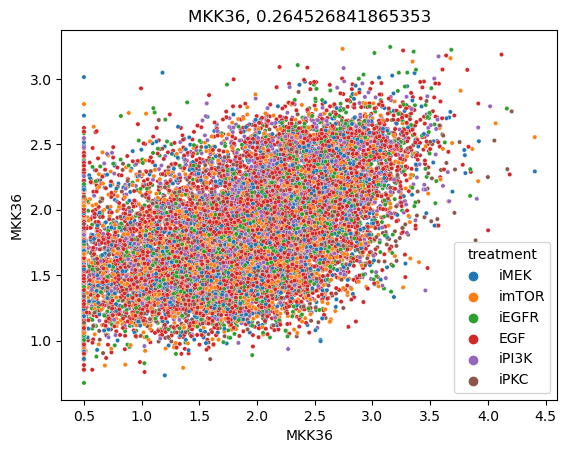

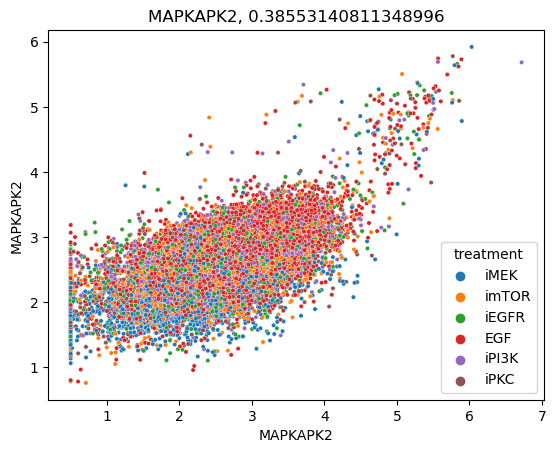

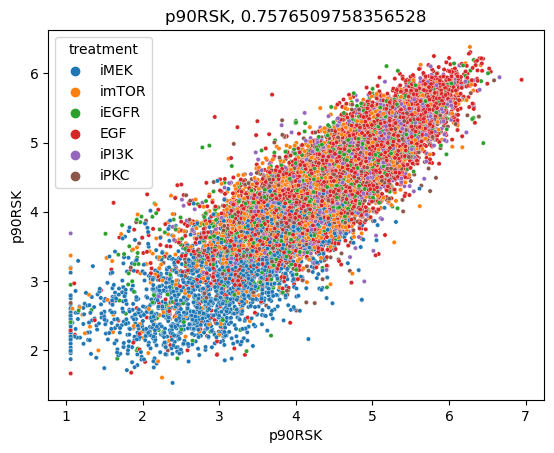

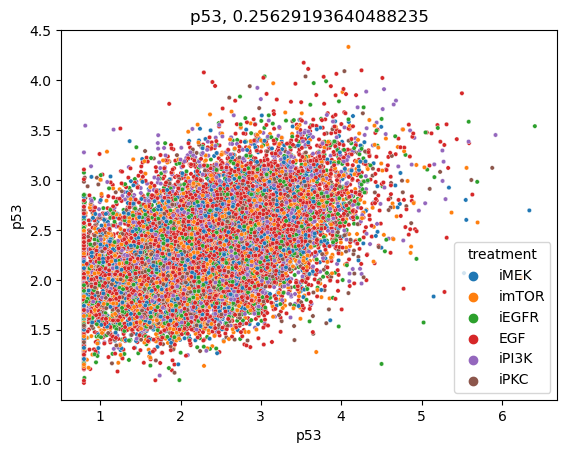

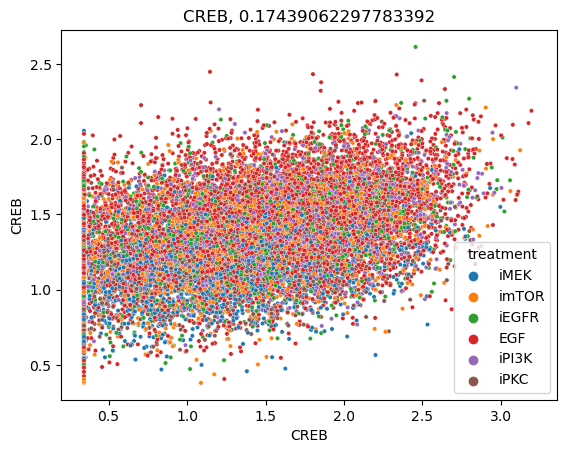

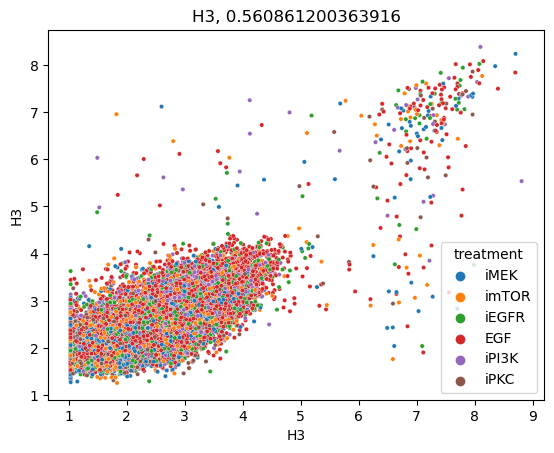

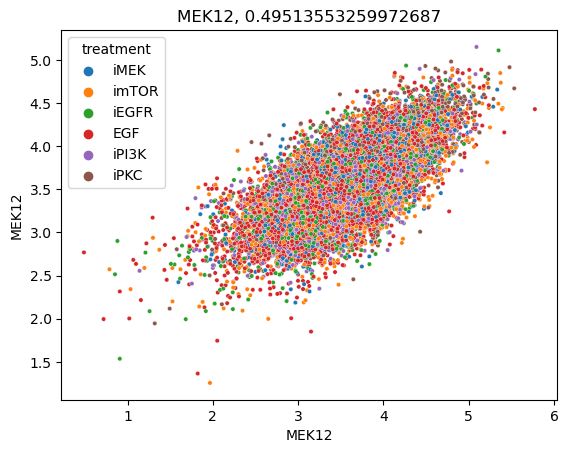

In [15]:
bl_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=bl_test[n], y=bl_pred[n], hue=bl_test["treatment"], s=10)
    r2 = r2_score(bl_test[n], bl_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    bl_r2.append(r2)

Text(0.5, 1.0, 'One cell line, mixed treatment on Subnetwork')

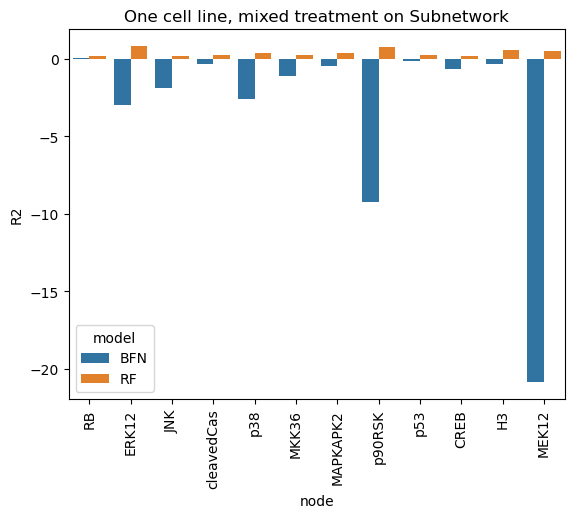

In [16]:
res = pd.DataFrame({"BFN": m_r2, "RF": bl_r2, "node": predicted_nodes})
res = res.melt(id_vars="node", value_vars=["BFN", "RF"], value_name="R2", var_name="model")
sns.barplot(data=res, x="node", y="R2", hue="model")
t = plt.xticks(rotation=90)
plt.title("One cell line, mixed treatment on Subnetwork")

# MEK FAK ERK

In [17]:
predicted_nodes = ["ERK12"]

In [18]:
client = mlflow.tracking.MlflowClient(tracking_uri="http://localhost:5000")
exp_id = client.get_experiment_by_name("OneCellLine_MEK_FAK_ERK").experiment_id
runs = client.search_runs(experiment_ids=exp_id)
runs_df = pd.DataFrame([{ **dict(run.info), **run.data.params, **run.data.metrics} for run in runs])

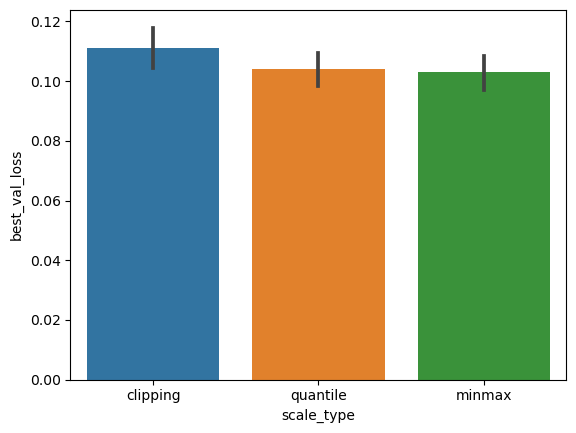

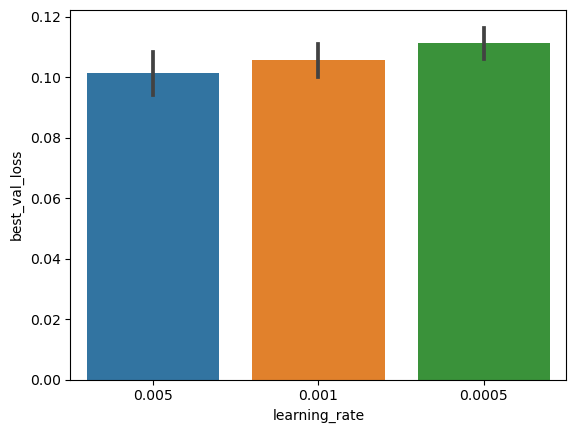

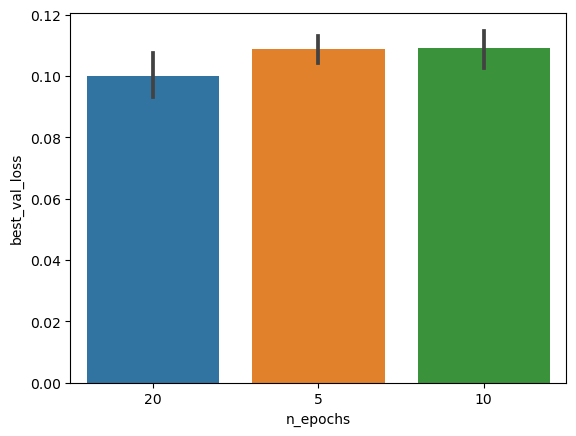

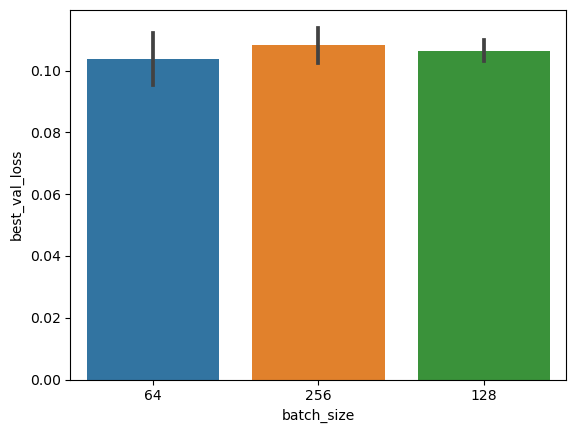

In [19]:

sns.barplot(data=runs_df, x="scale_type", y="best_val_loss")
plt.show()
sns.barplot(data=runs_df, x="learning_rate", y="best_val_loss")
plt.show()
sns.barplot(data=runs_df, x="n_epochs", y="best_val_loss")
plt.show()
sns.barplot(data=runs_df, x="batch_size", y="best_val_loss")
plt.show()

In [20]:
best_run = runs_df.sort_values("best_val_loss", ascending=True).iloc[0,:]
print(best_run["param_setting"])
print(best_run["scale_type"])
print(best_run["n_epochs"])
print(best_run["batch_size"])

24
minmax
20
64


In [21]:
for n in predicted_nodes:
    print(n, best_run[f"val_r2_{n}"])



ERK12 -6.358825277697898


In [22]:
model_dir = "/Users/adr/Box/CARs/BFN/Model/OneCellLine/"
m_test = pd.read_csv(os.path.join(model_dir, "valid_data.csv"), index_col = 0).reset_index(drop=True)
m_pred = pd.read_csv(os.path.join(model_dir, "valid_output_states.csv"), index_col=0)
with open(os.path.join(model_dir, "scaler.pkl"), "rb") as s:
    m_scaler = pickle.load(s)

/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


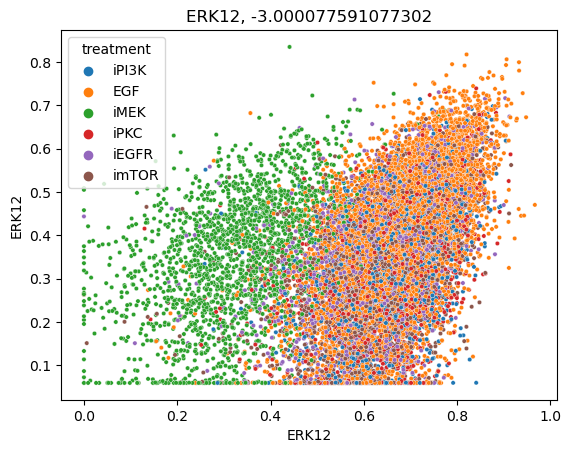

In [23]:
m_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=m_test[n], y=m_pred[n], hue=m_test["treatment"], s =10)
    r2 = r2_score(m_test[n], m_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    m_r2.append(r2)

In [24]:
baseline_dir = "/Users/adr/Box/CARs/BFN/Model/Baseline/RF_OneCellLine_MEK_FAK_ERK_MF_inputs/"
bl_test = np.load(os.path.join(baseline_dir, "RF_OneCellLine_test.npy"), allow_pickle=True)
bl_test = pd.DataFrame(bl_test).iloc[:, :40]
bl_test.columns = m_test.iloc[:, :40].columns

In [25]:
all_pred = []
names = []
for f in os.listdir(baseline_dir):
    if not f.startswith("RF_"):
        pred = np.load(os.path.join(baseline_dir, f))
        if "Cas" in f:
            name = f[:-4]
        elif "MEK" in f or "ERK" in f:
            name = f"{f[2:-4]}12"
        elif "MKK3.MKK6" in f:
            name = "MKK36"
        else:
            name = f[2:-4]
        
        all_pred.append(pred)
        names.append(name)
        
        print(name)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [ ]:
bl_pred = pd.DataFrame(all_pred).T
bl_pred.columns = names
bl_pred

In [ ]:
bl_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=bl_test[n], y=bl_pred[n], hue=bl_test["treatment"], s=10)
    r2 = r2_score(bl_test[n], bl_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    bl_r2.append(r2)

In [ ]:
res = pd.DataFrame({"BFN": m_r2, "RF": bl_r2, "node": predicted_nodes})
res = res.melt(id_vars="node", value_vars=["BFN", "RF"], value_name="R2", var_name="model")
sns.barplot(data=res, x="node", y="R2", hue="model")
t = plt.xticks(rotation=90)
plt.title("One cell line, mixed treatment on MEK FAK ERK")